# 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터

* 훈련데이터
[download trianing data](http://azuremlsamples.azureml.net/templatedata/PM_train.txt)  
* 테스트 데이터
[download test data](http://azuremlsamples.azureml.net/templatedata/PM_test.txt)  
* 정답 데이터
[download truth data](http://azuremlsamples.azureml.net/templatedata/PM_truth.txt)  

[보고서](https://www.dropbox.com/s/9bfvx1d13o5wyqy/Predictive%20Maintenance%20Project%20Report.pdf)

In [2]:
!curl http://azuremlsamples.azureml.net/templatedata/PM_train.txt \
    -o PM_train.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3432k  100 3432k    0     0  5721k      0 --:--:-- --:--:-- --:--:-- 5721k


In [3]:
!curl http://azuremlsamples.azureml.net/templatedata/PM_test.txt \
        -o PM_test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2176k  100 2176k    0     0  8741k      0 --:--:-- --:--:-- --:--:-- 8706k


In [4]:
!curl http://azuremlsamples.azureml.net/templatedata/PM_truth.txt \
        -o PM_truth.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   429  100   429    0     0  14793      0 --:--:-- --:--:-- --:--:-- 15321


### Data Columns

•	__id__: is the engine ID, ranging from 1 to 100  
•	__cycle__: per engine sequence, starts from 1 to the cycle number where failure had happened (trining data only)  
•	__setting1__ to __setting3__: engine operational settings  
•	__s1__ to __s21__: sensors measurements  


In [5]:
# 컬럼 이름
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

### Load Training Data:

In [6]:
df_train_raw = pd.read_csv('PM_train.txt', sep = ' ', header=None)
print(df_train_raw.shape)
df_train_raw.head()

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [7]:
# 불필요한 컬럼 삭제
df_train_raw.drop([26,27], axis=1, inplace=True)

In [8]:
df_train_raw.columns = col_names
df_train_raw.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
df_train_raw.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## 100개의 엔진이 있고 각각 1~362 사이클 실행 정보가 있다.
- 마지막 사이클 번호가 고장난 시점이다.

In [10]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
id          20631 non-null int64
cycle       20631 non-null int64
setting1    20631 non-null float64
setting2    20631 non-null float64
setting3    20631 non-null float64
s1          20631 non-null float64
s2          20631 non-null float64
s3          20631 non-null float64
s4          20631 non-null float64
s5          20631 non-null float64
s6          20631 non-null float64
s7          20631 non-null float64
s8          20631 non-null float64
s9          20631 non-null float64
s10         20631 non-null float64
s11         20631 non-null float64
s12         20631 non-null float64
s13         20631 non-null float64
s14         20631 non-null float64
s15         20631 non-null float64
s16         20631 non-null float64
s17         20631 non-null int64
s18         20631 non-null int64
s19         20631 non-null float64
s20         20631 non-null float64
s21         20631 non-nu

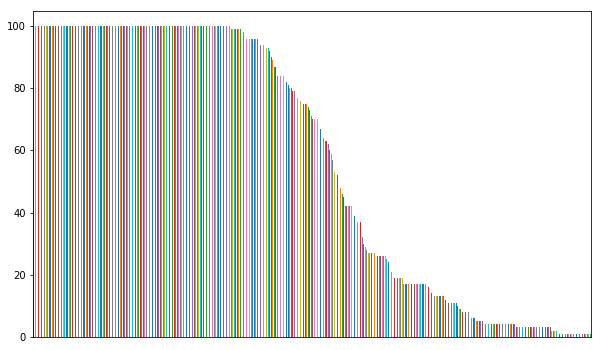

In [11]:
plt.figure(figsize=(10,10))
df_train_raw.cycle.value_counts().plot(kind='bar',figsize=(10,6))
plt.xticks([])
plt.show()

In [12]:
# 테스트 데이터
df_test_raw = pd.read_csv('PM_test.txt', sep = ' ', header=None)
print(df_test_raw.shape)
df_test_raw.head()

(13096, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [13]:
# 26, 27 열 삭제
df_test_raw.drop([26,27], axis=1, inplace=True)
df_test_raw.columns = col_names
df_test_raw.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [14]:
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
id          13096 non-null int64
cycle       13096 non-null int64
setting1    13096 non-null float64
setting2    13096 non-null float64
setting3    13096 non-null float64
s1          13096 non-null float64
s2          13096 non-null float64
s3          13096 non-null float64
s4          13096 non-null float64
s5          13096 non-null float64
s6          13096 non-null float64
s7          13096 non-null float64
s8          13096 non-null float64
s9          13096 non-null float64
s10         13096 non-null float64
s11         13096 non-null float64
s12         13096 non-null float64
s13         13096 non-null float64
s14         13096 non-null float64
s15         13096 non-null float64
s16         13096 non-null float64
s17         13096 non-null int64
s18         13096 non-null int64
s19         13096 non-null float64
s20         13096 non-null float64
s21         13096 non-nu

- 100개의 엔진이 있고 사이클 값은 1 ~ 303이다. 단, 여기서는 고장 시점을 알려주는 것은 아니다.
- 실제 고장 시점까진의 사이클 시간, remaining cycles before failure (time to failure, TTF)는 별도의 정답 파일에 들어 있다.

### Load Truth Data:

In [15]:
# 정답 파일 읽기
df_truth = pd.read_csv('PM_truth.txt', sep = ' ', header=None)
df_truth.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [16]:
# 불필요한 두번 째 컬럼 삭제, 컬럼 이름을 ttf로
df_truth.drop([1], axis=1, inplace=True)
df_truth.columns = ['ttf']
df_truth.head()

,ttf
0,112
1,98
2,69
3,82
4,91


In [17]:
# df_truth.ttf.value_counts().to_frame().plot(kind='bar')

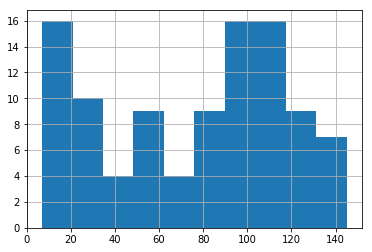

In [18]:
df_truth.ttf.hist(bins=10)

## 검증을 위해서, 테스트 데이터에 레이블 값을 컬럼에 추가하는 것이 필요하다.
## 추가 특성으로 이동평균값과 이동 표준편차를 추가한다.


### Feature Extraction 함수 정의

In [19]:
def add_features(df_in, rolling_win_size):
    
    sensor_cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
    
    sensor_av_cols = [nm.replace('s', 'av') for nm in sensor_cols]
    sensor_sd_cols = [nm.replace('s', 'sd') for nm in sensor_cols]
    
    df_out = pd.DataFrame()
    
    ws = rolling_win_size
        
    for m_id in pd.unique(df_in.id):
    
        # get a subset for each engine sensors
        df_engine = df_in[df_in['id'] == m_id]
        df_sub = df_engine[sensor_cols]

        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
    
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
    
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
    
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
        
    return df_out

## 훈련 데이터를 수정하여 회귀와 분류에 필요한 레이블을 컬럼에 추가한다

In [20]:
def prepare_train_data (df_in, period):

    # 각 엔진에 대해서 마지막 사이클 값을 저장하는 데이터 프레임 생성
    df_max_cycle = pd.DataFrame(df_in.groupby('id')['cycle'].max())
    df_max_cycle.reset_index(level=0, inplace=True)
    df_max_cycle.columns = ['id', 'last_cycle']
    
    # time-to-failure ttf 을 새로운 컬러에 기록 (회귀 레이블)
    df_in = pd.merge(df_in, df_max_cycle, on='id')
    df_in['ttf'] = df_in['last_cycle'] - df_in['cycle']
    df_in.drop(['last_cycle'], axis=1, inplace=True)
    
    # 이진 분류 레이블 작성
    df_in['label_bnc'] = df_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    # 다중 분류 레이블 작성
    df_in['label_mcc'] = df_in['ttf'].apply(lambda x: 2 if x <= period/2 else 1 if x <= period else 0)
    
    return df_in
    

테스트 데이터에 대해서 회귀레이블과 분류 데이블을 추가

In [21]:
def prepare_test_data(df_test_in, df_truth_in, period):
    
    df_tst_last_cycle = pd.DataFrame(df_test_in.groupby('id')['cycle'].max())
    
    df_tst_last_cycle.reset_index(level=0, inplace=True)
    df_tst_last_cycle.columns = ['id', 'last_cycle']
    
    df_test_in = pd.merge(df_test_in, df_tst_last_cycle, on='id')


    df_test_in = df_test_in[df_test_in['cycle'] == df_test_in['last_cycle']]

    df_test_in.drop(['last_cycle'], axis=1, inplace=True)
    
    df_test_in.reset_index(drop=True, inplace=True)
    
    df_test_in = pd.concat([df_test_in, df_truth], axis=1)
    
    #create binary classification label
    df_test_in['label_bnc'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    #create multi-class classification label
    df_test_in['label_mcc'] = df_test_in['ttf'].apply(lambda x: 2 if x <= period/2 else 1 if x <= period else 0)

    return df_test_in

## 훈련과 테스트 데이터에 대해서 위의 함수를 사용하여 레이블을 추가한다.

### Prepare the Training Data:

In [22]:
# 윈도우 크기를 5로 지정함
df_train_fx = add_features(df_train_raw, 5)
print(df_train_fx.shape)
df_train_fx.head()

(20631, 68)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.438406,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.404475,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.495950,0.029439,3.050906,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.432574,0.025884,2.651326,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498


## 분류를 수행하기 위해서 30 사이클을 기준으로 고장시점 예측
- 이진 분류: 30 사이클 이내에 고장 여부
- 다중 분류: 30 사이클 이내 및 15 사이클 이내 고장 여부


In [23]:
# 동작 상세 설명 검증
df_in, period = df_train_fx, 30

In [24]:
# 각 엔진에 대해서 마지막 사이클 값을 저장하는 데이터 프레임 생성
df_max_cycle = pd.DataFrame(df_in.groupby('id')['cycle'].max())
df_max_cycle

,cycle
id,
1,192
2,287
3,179
4,189
5,269
6,188
7,259
8,150
9,201


In [25]:
df_max_cycle.reset_index(level=0, inplace=True)
df_max_cycle.columns = ['id', 'last_cycle']
df_max_cycle[:10]

,id,last_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
5,6,188
6,7,259
7,8,150
8,9,201
9,10,222


In [26]:
df_max_cycle.last_cycle.values.mean() # 평균 수명

206.31

In [27]:
# time-to-failure ttf 을 새로운 컬러에 기록 (회귀 레이블)
df_in = pd.merge(df_in, df_max_cycle, on='id')
df_in[:20]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,last_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.029439,3.050906,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025884,2.651326,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,192
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,0.023452,0.958697,0.025727,0.0,1.140175,0.0,0.0,0.051186,0.031436,192
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,0.021679,0.643141,0.023476,0.0,1.140175,0.0,0.0,0.086718,0.021634,192
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,0.021679,1.149274,0.022477,0.0,0.836660,0.0,0.0,0.086487,0.034405,192
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,0.008944,3.205438,0.020740,0.0,0.836660,0.0,0.0,0.077136,0.038939,192
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,0.014142,2.883881,0.020493,0.0,0.836660,0.0,0.0,0.062849,0.058103,192


In [28]:
df_in['ttf'] = df_in['last_cycle'] - df_in['cycle']
df_in.drop(['last_cycle'], axis=1, inplace=True)
df_in[:20]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.035355,5.041671,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.026458,3.717450,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.029439,3.050906,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025884,2.651326,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,0.023452,0.958697,0.025727,0.0,1.140175,0.0,0.0,0.051186,0.031436,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,0.021679,0.643141,0.023476,0.0,1.140175,0.0,0.0,0.086718,0.021634,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,0.021679,1.149274,0.022477,0.0,0.836660,0.0,0.0,0.086487,0.034405,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,0.008944,3.205438,0.020740,0.0,0.836660,0.0,0.0,0.077136,0.038939,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,0.014142,2.883881,0.020493,0.0,0.836660,0.0,0.0,0.062849,0.058103,182


In [29]:
# 이진 분류 레이블 작성
df_in['label_bnc'] = df_in['ttf'].apply(lambda x: 1 if x <= period else 0)

# 다중 분류 레이블 작성
df_in['label_mcc'] = df_in['ttf'].apply(lambda x: 2 if x <= period/2 else 1 if x <= period else 0)

In [30]:
# df_train = prepare_train_data (df_train_fx, 30)
df_train = df_in
print(df_train.shape)
df_train.head()

(20631, 71)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


## 전처리된 데이터를 파일로 저장
### 나중을 위하여 자신이 구글 드라이브에 저장

In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
# 코랩에서
# df_train.to_csv('/content/drive/My Drive/PM_train.csv', index=False)

In [34]:
# PC에서
df_train.to_csv('w5_PM_train.csv', index=False)
# https://bit.ly/33aJCVy

### Prepare the Test Data:

In [35]:
# 같은 작업을 테스트 데이터에 대해서 수행
df_test_fx = add_features(df_test_raw, 5)
print(df_test_fx.shape)
df_test_fx.head()

(13096, 68)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.311127,0.021213,9.948992,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.220681,0.017321,7.179807,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.337182,0.015000,5.890096,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.329742,0.014142,5.222300,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672


In [36]:
# 검증
df_test_in, df_truth_in, period = df_test_fx, df_truth, 30
    
df_tst_last_cycle = pd.DataFrame(df_test_in.groupby('id')['cycle'].max())
df_tst_last_cycle[:10]

,cycle
id,
1,31
2,49
3,126
4,106
5,98
6,105
7,160
8,166
9,55


In [37]:
df_tst_last_cycle.cycle.values.sum() # 총 샘플수

13096

In [38]:
df_tst_last_cycle.cycle.values # 기록된 데이터 중 최대 사이클 수

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198])

In [39]:
df_truth.ttf.values # 실제 수명

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

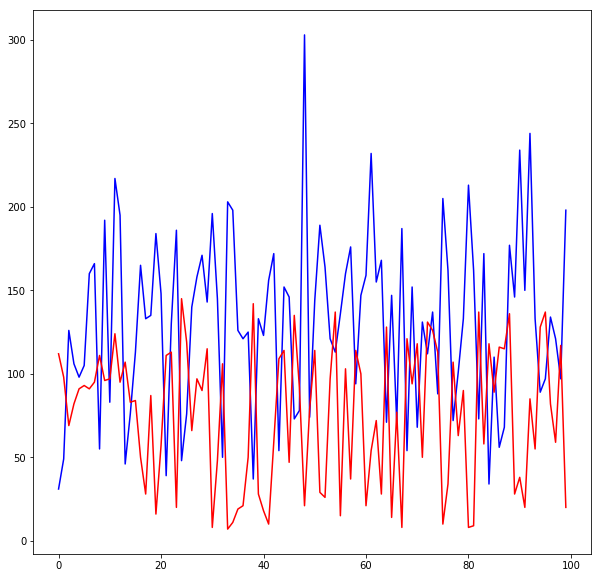

In [40]:
plt.figure(figsize=(10,10))
plt.plot(df_tst_last_cycle.cycle.values, c='b')
plt.plot(df_truth.ttf.values, c='r')
# plt.plot(df_tst_last_cycle.cycle.values+df_truth.ttf.values, c='k')

In [41]:
test_ttf = df_tst_last_cycle.cycle.values+df_truth.ttf.values

In [42]:
test_ttf.mean() # 테스트 데이터의 평균 수명

206.48

In [43]:
df_tst_last_cycle['last_cycle'] = test_ttf
df_tst_last_cycle[:10]

,cycle,last_cycle
id,,
1,31,143
2,49,147
3,126,195
4,106,188
5,98,189
6,105,198
7,160,251
8,166,261
9,55,166


In [44]:
df_tst_last_cycle.drop(["cycle"], axis=1, inplace = True)

In [45]:
df_tst_last_cycle[:5]

,last_cycle
id,
1,143
2,147
3,195
4,188
5,189


In [46]:
df_test_in[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.311127,0.021213,9.948992,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.220681,0.017321,7.179807,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.337182,0.015000,5.890096,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.329742,0.014142,5.222300,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672


In [47]:
df_tst_last_cycle.reset_index(level=0, inplace=True)
df_tst_last_cycle.columns = ['id', 'last_cycle']
df_test_in = pd.merge(df_test_in, df_tst_last_cycle, on='id')
df_test_in['ttf'] = df_test_in['last_cycle'] - df_test_in['cycle']
df_test_in[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,last_cycle,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,9.948992,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,7.179807,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,5.890096,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,5.222300,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672,143,138


In [48]:
df_test_in.shape

(13096, 70)

In [49]:
df_test_in.drop(['last_cycle'], axis=1, inplace=True)
df_test_in[:5]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.021213,9.948992,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.017321,7.179807,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.015000,5.890096,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.014142,5.222300,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672,138


In [50]:
#create binary classification label
df_test_in['label_bnc'] = df_test_in['ttf'].apply(lambda x: 1 if x <= period else 0)

#create multi-class classification label
df_test_in['label_mcc'] = df_test_in['ttf'].apply(lambda x: 2 if x <= period/2 else 1 if x <= period else 0)

In [51]:
# 분류를 위한 레이블 추가, 고장 시점은 'ttf' 컬럼에 저장

# df_test = prepare_test_data(df_test_fx, df_truth, 30)
print(df_test_in.shape)
df_test_in.head()

(13096, 71)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672,138,0,0


In [52]:
# df_test_in.to_csv('/content/drive/My Drive/PM_test.csv', index=False)

In [53]:
df_test_in.to_csv('w5_PM_test.csv', index=False)

# https://bit.ly/39N0hzR